### Using the model for predictions until 2072

In [1]:
""" Import packages """
import os
from datetime import datetime
import pickle
import sys
import logging
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.insert(0, '../scripts/')

logging.basicConfig(filename='../logs/modeling.log', filemode='a',
                    encoding='utf-8', level=logging.DEBUG)

warnings.filterwarnings("ignore")

from keras.models import load_model

2023-12-06 18:45:21.075464: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 18:45:22.616258: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from explorer import DataTransformer
from utils_cleaner import DataFrameCleaner
from utils_plots import EDAPlots
from feature_engineering import FeatureEnginnering

transformer = DataTransformer() 
plotmaker = EDAPlots()

In [3]:
from predictions import format_data_column_names, predict_malaria_dynamics_with_target_lag

In [4]:
REPO = "../"
filepath_model = "../data/cleaned/final/cleaned_project_dataset.csv"
rev_model = "clpdat3n"

filepath_futur = "../data/cleaned/final/downloaded_projections_data.csv"
rev_futur = "cldfdat2"


### Import the model data

In [5]:
data = transformer.load_data(ext="csv", filepath=filepath_model, repo=REPO, rev=rev_model, header=0, parse_dates=["Date"])
data.head()

,Country,ISO3,Date,Target_1,Target_2,Target_3,Feature_1,Feature_2,Feature_3,Feature_4,...,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25,Feature_26,Feature_27,Feature_28,Feature_29,Feature_30
0,Burkina Faso,BFA,2000-12-31,603.21100,874.85,249.82,2.55,43.4316,15.4232,3.020,...,6.857565,9762505.0,714.73,29.06,22.72,0,0,0.0,0.0,0.0
1,Burkina Faso,BFA,2001-12-31,601.93774,918.92,264.60,2.97,44.7725,15.5302,3.060,...,6.867020,9978658.0,749.26,29.19,22.77,0,0,0.0,0.0,0.0
2,Burkina Faso,BFA,2002-12-31,595.85205,958.85,274.54,2.90,46.1706,15.6492,3.089,...,6.874386,10199547.0,690.37,29.47,23.24,0,0,0.0,0.0,0.0
3,Burkina Faso,BFA,2003-12-31,585.12330,965.41,278.27,2.60,47.6264,15.7656,3.120,...,6.865103,10424994.0,935.59,29.34,23.12,0,0,0.0,0.0,0.0
4,Burkina Faso,BFA,2004-12-31,562.41130,925.19,267.83,3.00,49.1447,15.8710,3.156,...,6.873132,10654996.0,752.75,29.41,23.25,0,0,0.0,0.0,0.0


In [6]:
### data columns meaning

### Renaming the columns
potential_targets = ['Malaria_Incidence', 'Malaria_Deaths_U5', 'Malaria_Deaths']

potential_features = ['ITN_Access', 'PopDensity', 'MedianAgePop',
       'PopGrowthRate', 'TFR', 'IMR', 'Q5', 'CNMR',
       'Population ages 0-14 (% of total population)',
       'Population ages 15-64 (% of total population)',
       'Domestic general government health expenditure (% of general government expenditure)',
       'External health expenditure (% of current health expenditure)',
       'People using at least basic sanitation services, rural (% of rural population)',
       'People using safely managed sanitation services, rural (% of rural population)',
       'Population living in slums (% of urban population)',
       'Foreign direct investment, net inflows (% of GDP)',
       'Mortality rate, under-5 (per 1,000 live births)',
       'Population growth (annual %)',
       'Population in urban agglomerations of more than 1 million (% of total population)',
       'Urban population (% of total population)',
       'Urban population growth (annual %)', 'Rural population',
       'Precipitation', 'Average Mean Surface Air Temperature',
       'Average Minimum Surface Air Temperature', 'Leveraged RTS Vaccine',
       'Leveraged R21 Vaccine', 'Vaccinated Aged 0',
       'Effectively_protected (0-5)', 'Vaccinated_still_susceptibles (0-5)']

new_column_names = {i: f"Target_{potential_targets.index(i)+1}" for i in potential_targets}
features_names = {i: f"Feature_{potential_features.index(i)+1}" for i in potential_features}

new_column_names.update(features_names)
new_column_names

{'Malaria_Incidence': 'Target_1',
 'Malaria_Deaths_U5': 'Target_2',
 'Malaria_Deaths': 'Target_3',
 'ITN_Access': 'Feature_1',
 'PopDensity': 'Feature_2',
 'MedianAgePop': 'Feature_3',
 'PopGrowthRate': 'Feature_4',
 'TFR': 'Feature_5',
 'IMR': 'Feature_6',
 'Q5': 'Feature_7',
 'CNMR': 'Feature_8',
 'Population ages 0-14 (% of total population)': 'Feature_9',
 'Population ages 15-64 (% of total population)': 'Feature_10',
 'Domestic general government health expenditure (% of general government expenditure)': 'Feature_11',
 'External health expenditure (% of current health expenditure)': 'Feature_12',
 'People using at least basic sanitation services, rural (% of rural population)': 'Feature_13',
 'People using safely managed sanitation services, rural (% of rural population)': 'Feature_14',
 'Population living in slums (% of urban population)': 'Feature_15',
 'Foreign direct investment, net inflows (% of GDP)': 'Feature_16',
 'Mortality rate, under-5 (per 1,000 live births)': 'Feature

In [7]:
list_drop = ["Feature_2", "Feature_3", "Feature_17", "Feature_18", "Feature_19", "Feature_20"]
data.drop(columns=list_drop, inplace=True)

### Import the current future data

In [8]:
futur_data = transformer.load_data(ext="csv", filepath=filepath_futur, repo=REPO, rev=rev_futur, header=0, parse_dates=["Date"])
futur_data.drop(columns=futur_data.columns[0], inplace=True)
futur_data.head()

,Date,Precipitation_SSP2-4.5,Average Mean Surface Air Temperature_SSP2-4.5,Average Minimum Surface Air Temperature_SSP2-4.5,ISO3,Country,PopDensity,MedianAgePop,PopGrowthRate,TFR,...,Total Aged 2 (thousand),Total Aged 3 (thousand),Total Aged 4 (thousand),Total Aged 5 (thousand),Probablity of surviving at age 0,Probablity of surviving at age 1,Probablity of surviving at age 2,Probablity of surviving at age 3,Probablity of surviving at age 4,Probablity of surviving at age 5
0,2023-12-31,664.92,29.13,23.46,BFA,Burkina Faso,84.9835,16.8720,2.512,4.5664,...,729.1135,713.9270,700.5295,687.5185,0.953906,0.987339,0.990856,0.993340,0.995081,0.996293
1,2024-12-31,695.90,29.43,23.73,BFA,Burkina Faso,87.1354,17.0439,2.490,4.4729,...,737.9945,723.1505,709.6280,697.3710,0.953884,0.987206,0.990761,0.993273,0.995034,0.996260
2,2025-12-31,667.79,29.30,23.58,BFA,Burkina Faso,89.3162,17.2362,2.454,4.3812,...,745.9260,731.8280,718.7030,706.3620,0.952666,0.986765,0.990440,0.993038,0.994862,0.996132
3,2026-12-31,704.17,29.38,23.68,BFA,Burkina Faso,91.5219,17.4412,2.425,4.2950,...,753.9120,739.6450,727.2920,715.3700,0.953366,0.987000,0.990606,0.993157,0.994947,0.996195
4,2027-12-31,655.76,29.40,23.78,BFA,Burkina Faso,93.7533,17.6535,2.393,4.2068,...,762.1910,747.6750,735.1390,723.9760,0.954083,0.987240,0.990776,0.993278,0.995035,0.996260


In [9]:
futur_data.columns

Index(['Date', 'Precipitation_SSP2-4.5',
       'Average Mean Surface Air Temperature_SSP2-4.5',
       'Average Minimum Surface Air Temperature_SSP2-4.5', 'ISO3', 'Country',
       'PopDensity', 'MedianAgePop', 'PopGrowthRate', 'TFR', 'IMR', 'Q5',
       'CNMR', 'Total Aged 0 (thousand)', 'Total Aged 1 (thousand)',
       'Total Aged 2 (thousand)', 'Total Aged 3 (thousand)',
       'Total Aged 4 (thousand)', 'Total Aged 5 (thousand)',
       'Probablity of surviving at age 0', 'Probablity of surviving at age 1',
       'Probablity of surviving at age 2', 'Probablity of surviving at age 3',
       'Probablity of surviving at age 4', 'Probablity of surviving at age 5'],
      dtype='object')

In [10]:
futur_data.rename(
    columns={
        'Precipitation_SSP2-4.5': 'Precipitation',
        'Average Mean Surface Air Temperature_SSP2-4.5': 'Average Mean Surface Air Temperature',
        'Average Minimum Surface Air Temperature_SSP2-4.5': 'Average Minimum Surface Air Temperature',
    }, inplace=True
)

In [11]:
set(new_column_names.keys()).difference(set(futur_data.columns))

{'Domestic general government health expenditure (% of general government expenditure)',
 'Effectively_protected (0-5)',
 'External health expenditure (% of current health expenditure)',
 'Foreign direct investment, net inflows (% of GDP)',
 'ITN_Access',
 'Leveraged R21 Vaccine',
 'Leveraged RTS Vaccine',
 'Malaria_Deaths',
 'Malaria_Deaths_U5',
 'Malaria_Incidence',
 'Mortality rate, under-5 (per 1,000 live births)',
 'People using at least basic sanitation services, rural (% of rural population)',
 'People using safely managed sanitation services, rural (% of rural population)',
 'Population ages 0-14 (% of total population)',
 'Population ages 15-64 (% of total population)',
 'Population growth (annual %)',
 'Population in urban agglomerations of more than 1 million (% of total population)',
 'Population living in slums (% of urban population)',
 'Rural population',
 'Urban population (% of total population)',
 'Urban population growth (annual %)',
 'Vaccinated Aged 0',
 'Vaccinate

In [12]:
remaining_columns = ['Domestic general government health expenditure (% of general government expenditure)',
 'External health expenditure (% of current health expenditure)',
 'Foreign direct investment, net inflows (% of GDP)',
 'ITN_Access',
#  'Mortality rate, under-5 (per 1,000 live births)',
 'People using at least basic sanitation services, rural (% of rural population)',
 'People using safely managed sanitation services, rural (% of rural population)',
 'Population ages 0-14 (% of total population)',
 'Population ages 15-64 (% of total population)',
#  'Population growth (annual %)',
#  'Population in urban agglomerations of more than 1 million (% of total population)',
 'Population living in slums (% of urban population)',
 'Rural population',
#  'Urban population (% of total population)',
 'Urban population growth (annual %)']

remaining_columns_dict = {column: new_column_names[column] for column in remaining_columns}

#### Create remaining needed projections columns 

In [13]:
create_feat_future = FeatureEnginnering(futur_data)

In [14]:
futur_data_plus = create_feat_future.create_remaining_futur_columns(split_column="ISO3", last_data=data, remaining_columns=remaining_columns, remaining_columns_dict=remaining_columns_dict)

In [15]:
set(new_column_names.keys()).difference(set(futur_data_plus.columns))

{'Effectively_protected (0-5)',
 'Leveraged R21 Vaccine',
 'Leveraged RTS Vaccine',
 'Malaria_Deaths',
 'Malaria_Deaths_U5',
 'Malaria_Incidence',
 'Mortality rate, under-5 (per 1,000 live births)',
 'Population growth (annual %)',
 'Population in urban agglomerations of more than 1 million (% of total population)',
 'Urban population (% of total population)',
 'Vaccinated Aged 0',
 'Vaccinated_still_susceptibles (0-5)'}

#### Scenario_1: No vaccination at all

In [16]:
data_s1 = futur_data_plus.copy()

In [17]:
data_s1[['Leveraged R21 Vaccine', 'Leveraged RTS Vaccine']] = 0

In [18]:
create_feat_future_s1 = FeatureEnginnering(data_s1)
data_s1 = create_feat_future_s1.create_new_features_for_future(column="ISO3", coverage_0=0, coverage_2=0, initial_efficacy=0, efficacy_booster=0)

In [19]:
set(new_column_names.keys()).difference(set(data_s1.columns))

{'Malaria_Deaths',
 'Malaria_Deaths_U5',
 'Malaria_Incidence',
 'Mortality rate, under-5 (per 1,000 live births)',
 'Population growth (annual %)',
 'Population in urban agglomerations of more than 1 million (% of total population)',
 'Urban population (% of total population)'}

#### Scenario_2-1: Potential vaccination using RTS from 2023 with ralatively high coverage

- coverage_0=0.8
- coverage_2=0.9
- initial_efficacy=0.76
- efficacy_booster=0.52

In [20]:
data_s21 = futur_data_plus.copy()

In [21]:
# data_s21['In MVIP'] = 0
data_s21['Leveraged R21 Vaccine'] = 0
data_s21['Leveraged RTS Vaccine'] = 1

In [22]:
create_feat_future_s21 = FeatureEnginnering(data_s21)
data_s21 = create_feat_future_s21.create_new_features_for_future(column="ISO3", coverage_0=0.8, coverage_2=0.9, initial_efficacy=0.76, efficacy_booster=0.52)

In [23]:
set(new_column_names.keys()).difference(set(data_s21.columns))

{'Malaria_Deaths',
 'Malaria_Deaths_U5',
 'Malaria_Incidence',
 'Mortality rate, under-5 (per 1,000 live births)',
 'Population growth (annual %)',
 'Population in urban agglomerations of more than 1 million (% of total population)',
 'Urban population (% of total population)'}

#### Scenario_2-2: Potential vaccination using RTS from 2023 with ralatively low coverage

- coverage_0=0.3
- coverage_2=0.9
- initial_efficacy=0.76
- efficacy_booster=0.52

In [24]:
data_s22 = futur_data_plus.copy()

In [25]:
# data_s22['In MVIP'] = 0
data_s22['Leveraged R21 Vaccine'] = 0
data_s22['Leveraged RTS Vaccine'] = 1

In [26]:
create_feat_future_s22 = FeatureEnginnering(data_s22)
data_s22 = create_feat_future_s22.create_new_features_for_future(column="ISO3", coverage_0=0.3, coverage_2=0.9, initial_efficacy=0.76, efficacy_booster=0.52)

In [27]:
set(new_column_names.keys()).difference(set(data_s22.columns))

{'Malaria_Deaths',
 'Malaria_Deaths_U5',
 'Malaria_Incidence',
 'Mortality rate, under-5 (per 1,000 live births)',
 'Population growth (annual %)',
 'Population in urban agglomerations of more than 1 million (% of total population)',
 'Urban population (% of total population)'}

#### Scenario_3-1: Potential vaccination using R21 from 2023 with relatively high coverage

- coverage_0=0.8
- coverage_2=0.9
- initial_efficacy=0.79
- efficacy_booster=0.79

In [28]:
data_s31 = futur_data_plus.copy()

In [29]:
# data_s31['In MVIP'] = 0
data_s31['Leveraged R21 Vaccine'] = 1
data_s31['Leveraged RTS Vaccine'] = 0

In [30]:
create_feat_future_s31 = FeatureEnginnering(data_s31)
data_s31 = create_feat_future_s31.create_new_features_for_future(column="ISO3", coverage_0=0.8, coverage_2=0.9, initial_efficacy=0.79, efficacy_booster=0.79, r21=True)

In [31]:
set(new_column_names.keys()).difference(set(data_s31.columns))

{'Malaria_Deaths',
 'Malaria_Deaths_U5',
 'Malaria_Incidence',
 'Mortality rate, under-5 (per 1,000 live births)',
 'Population growth (annual %)',
 'Population in urban agglomerations of more than 1 million (% of total population)',
 'Urban population (% of total population)'}

#### Scenario_3-2: Potential vaccination using R21 from 2023 with ralatively low coverage

- coverage_0=0.3
- coverage_2=0.9
- initial_efficacy=0.79
- efficacy_booster=0.79

In [32]:
data_s32 = futur_data_plus.copy()

In [33]:
# data_s32['In MVIP'] = 0
data_s32['Leveraged R21 Vaccine'] = 0
data_s32['Leveraged RTS Vaccine'] = 1

In [34]:
create_feat_future_s32 = FeatureEnginnering(data_s32)
data_s32 = create_feat_future_s32.create_new_features_for_future(column="ISO3", coverage_0=0.3, coverage_2=0.9, initial_efficacy=0.79, efficacy_booster=0.79, r21=True)

In [35]:
set(new_column_names.keys()).difference(set(data_s32.columns))

{'Malaria_Deaths',
 'Malaria_Deaths_U5',
 'Malaria_Incidence',
 'Mortality rate, under-5 (per 1,000 live births)',
 'Population growth (annual %)',
 'Population in urban agglomerations of more than 1 million (% of total population)',
 'Urban population (% of total population)'}

## Predictions

### Import the model

In [36]:
model = load_model('../models/LSTM_MBIOST/Time_lag_1/20231206_112403/20231206_112403/models/lstm_20231206_112403.h5')

2023-12-06 18:45:34.287500: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [37]:
scores_file = '../models/LSTM_MBIOST/Time_lag_1/20231206_112403/lstm_scores_20231206_112403.pkl'
# 1 '../models/LSTM_MBIOST/Time_lag_1/20231206_112403/lstm_scores_20231206_112403.pkl'
# 2 '../models/LSTM_MBIOST/Time_lag_1/20231206_183140/lstm_scores_20231206_183140.pkl'
with open(scores_file, 'rb') as f:
    actefacts = pickle.load(f)

In [38]:
actefacts['scores']

{'R2': {'train': 0.976, 'test': 0.916}, 'MAE': {'train': 0.11, 'test': 0.121}}

In [39]:
scaler_inputs, scaler_targets = actefacts['scalers']

In [40]:
index_cols = ["ISO3", "Country", "Date"]
target_columns = [col for col in data.columns if col.startswith("Target")]
input_columns = [col for col in data.columns if col.startswith("Feature")] + target_columns
feature_columns = [col for col in data.columns if col.startswith("Feature")]

In [41]:
seq_length = 1

### Scenario 1

In [42]:
data_s1 = format_data_column_names(data_s1)

In [43]:
data_s1 = data_s1[feature_columns].reset_index()

In [44]:
last_2_years_data = data[(data["Date"]>="2022-12-31") & (data.Country.isin(futur_data_plus.Country.unique()))]
data_s1 = pd.concat([last_2_years_data, data_s1])
data_s1 = data_s1.sort_values(by=index_cols, ascending=True)

In [45]:
predictions_s1 = predict_malaria_dynamics_with_target_lag(
    data=data_s1,
    model=model,
    seq_length=seq_length,
    scaler_inputs=scaler_inputs,
    scaler_targets=scaler_targets,
    input_columns=input_columns,
    target_columns=target_columns    
)

1/1 [==============================] - 0s 29ms/step


In [46]:
# targets_dict = {
#     "Target_1": 'Malaria Incidence for 1,000 people at risk',
#     "Target_2": 'Malaria Deaths rate under 5 (for 100,000)',
#     "Target_3": "Malaria Deaths rate (for 100,000)",
# }
# plotmaker.evolution_plot_per_country(
#     data=predictions_s1.reset_index(),
#     country_column="Country",
#     x_column="Date",
#     variables=list(targets_dict.keys()), 
#     nrows=2, 
#     ncols=2, 
#     figsize=(20, 15), 
#     nfigs=3, 
#     centered=True, 
#     subtitles=list(targets_dict.values()),
#     scenario="(Scenario 1)",
#     predictions=True
# )

### Scenario 2-1

In [47]:
data_s21 = format_data_column_names(data_s21)

In [48]:
data_s21 = data_s21[feature_columns].reset_index()

In [49]:
last_2_years_data = data[(data["Date"]>="2022-12-31") & (data.Country.isin(futur_data_plus.Country.unique()))]
data_s21 = pd.concat([last_2_years_data, data_s21])
data_s21 = data_s21.sort_values(by=index_cols, ascending=True)

In [50]:
predictions_s21 = predict_malaria_dynamics_with_target_lag(
    data=data_s21,
    model=model,
    seq_length=seq_length,
    scaler_inputs=scaler_inputs,
    scaler_targets=scaler_targets,
    input_columns=input_columns,
    target_columns=target_columns    
)

1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 30ms/step


In [51]:
# plotmaker.evolution_plot_per_country(
#     data=predictions_s21.reset_index(),
#     country_column="Country",
#     x_column="Date",
#     variables=list(targets_dict.keys()), 
#     nrows=2, 
#     ncols=2, 
#     figsize=(20, 15), 
#     nfigs=3, 
#     centered=True, 
#     subtitles=list(targets_dict.values()),
#     scenario="(Scenario 2-1)",
#     predictions=True
# )

### Scenario 2-2

In [52]:
# data_s22 = format_data_column_names(data_s22)

In [53]:
# data_s22 = data_s22[feature_columns].reset_index()

In [54]:
# last_2_years_data = data[(data["Date"]>="2022-12-31") & (data.Country.isin(futur_data_plus.Country.unique()))]
# data_s22 = pd.concat([last_2_years_data, data_s22])
# data_s22 = data_s22.sort_values(by=index_cols, ascending=True)

In [55]:
# predictions_s22 = predict_malaria_dynamics_with_target_lag(
#     data=data_s22,
#     model=model,
#     seq_length=seq_length,
#     scaler_inputs=scaler_inputs,
#     scaler_targets=scaler_targets,
#     input_columns=input_columns,
#     target_columns=target_columns    
# )

In [56]:
# plotmaker.evolution_plot_per_country(
#     data=predictions_s22.reset_index(),
#     country_column="Country",
#     x_column="Date",
#     variables=list(targets_dict.keys()), 
#     nrows=2, 
#     ncols=2, 
#     figsize=(20, 15), 
#     nfigs=3, 
#     centered=True, 
#     subtitles=list(targets_dict.values()),
#     scenario="(Scenario 2-2)",
#     predictions=True
# )

### Scenario 3-1

In [57]:
data_s31 = format_data_column_names(data_s31)

In [58]:
data_s31 = data_s31[feature_columns].reset_index()

In [59]:
last_2_years_data = data[(data["Date"]>="2022-12-31") & (data.Country.isin(futur_data_plus.Country.unique()))]
data_s31 = pd.concat([last_2_years_data, data_s31])
data_s31 = data_s31.sort_values(by=index_cols, ascending=True)

In [60]:
predictions_s31 = predict_malaria_dynamics_with_target_lag(
    data=data_s31,
    model=model,
    seq_length=seq_length,
    scaler_inputs=scaler_inputs,
    scaler_targets=scaler_targets,
    input_columns=input_columns,
    target_columns=target_columns    
)

1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 25ms/step


In [61]:
# plotmaker.evolution_plot_per_country(
#     data=predictions_s31.reset_index(),
#     country_column="Country",
#     x_column="Date",
#     variables=list(targets_dict.keys()), 
#     nrows=2, 
#     ncols=2, 
#     figsize=(20, 15), 
#     nfigs=3, 
#     centered=True, 
#     subtitles=list(targets_dict.values()),
#     scenario="(Scenario 3-1)",
#     predictions=True
# )

### Scenario 3-2

In [62]:
# data_s32 = format_data_column_names(data_s32)

In [63]:
# data_s32 = data_s32[feature_columns].reset_index()

In [64]:
# last_2_years_data = data[(data["Date"]>="2022-12-31") & (data.Country.isin(futur_data_plus.Country.unique()))]
# data_s32 = pd.concat([last_2_years_data, data_s32])
# data_s32 = data_s32.sort_values(by=index_cols, ascending=True)

In [65]:
# predictions_s32 = predict_malaria_dynamics_with_target_lag(
#     data=data_s32,
#     model=model,
#     seq_length=seq_length,
#     scaler_inputs=scaler_inputs,
#     scaler_targets=scaler_targets,
#     input_columns=input_columns,
#     target_columns=target_columns    
# )

In [66]:
# plotmaker.evolution_plot_per_country(
#     data=predictions_s32.reset_index(),
#     country_column="Country",
#     x_column="Date",
#     variables=list(targets_dict.keys()), 
#     nrows=2, 
#     ncols=2, 
#     figsize=(20, 15), 
#     nfigs=3, 
#     centered=True, 
#     subtitles=list(targets_dict.values()),
#     scenario="(Scenario 3-2)",
#     predictions=True
# )

#### Plot predictions

In [67]:
predictions_s1["Scenario"] = "Scenario 1"
predictions_s21["Scenario"] = "Scenario 2"
predictions_s31["Scenario"] = "Scenario 3"

predictions = pd.concat([predictions_s1, predictions_s21, predictions_s31])

### Burkina Faso

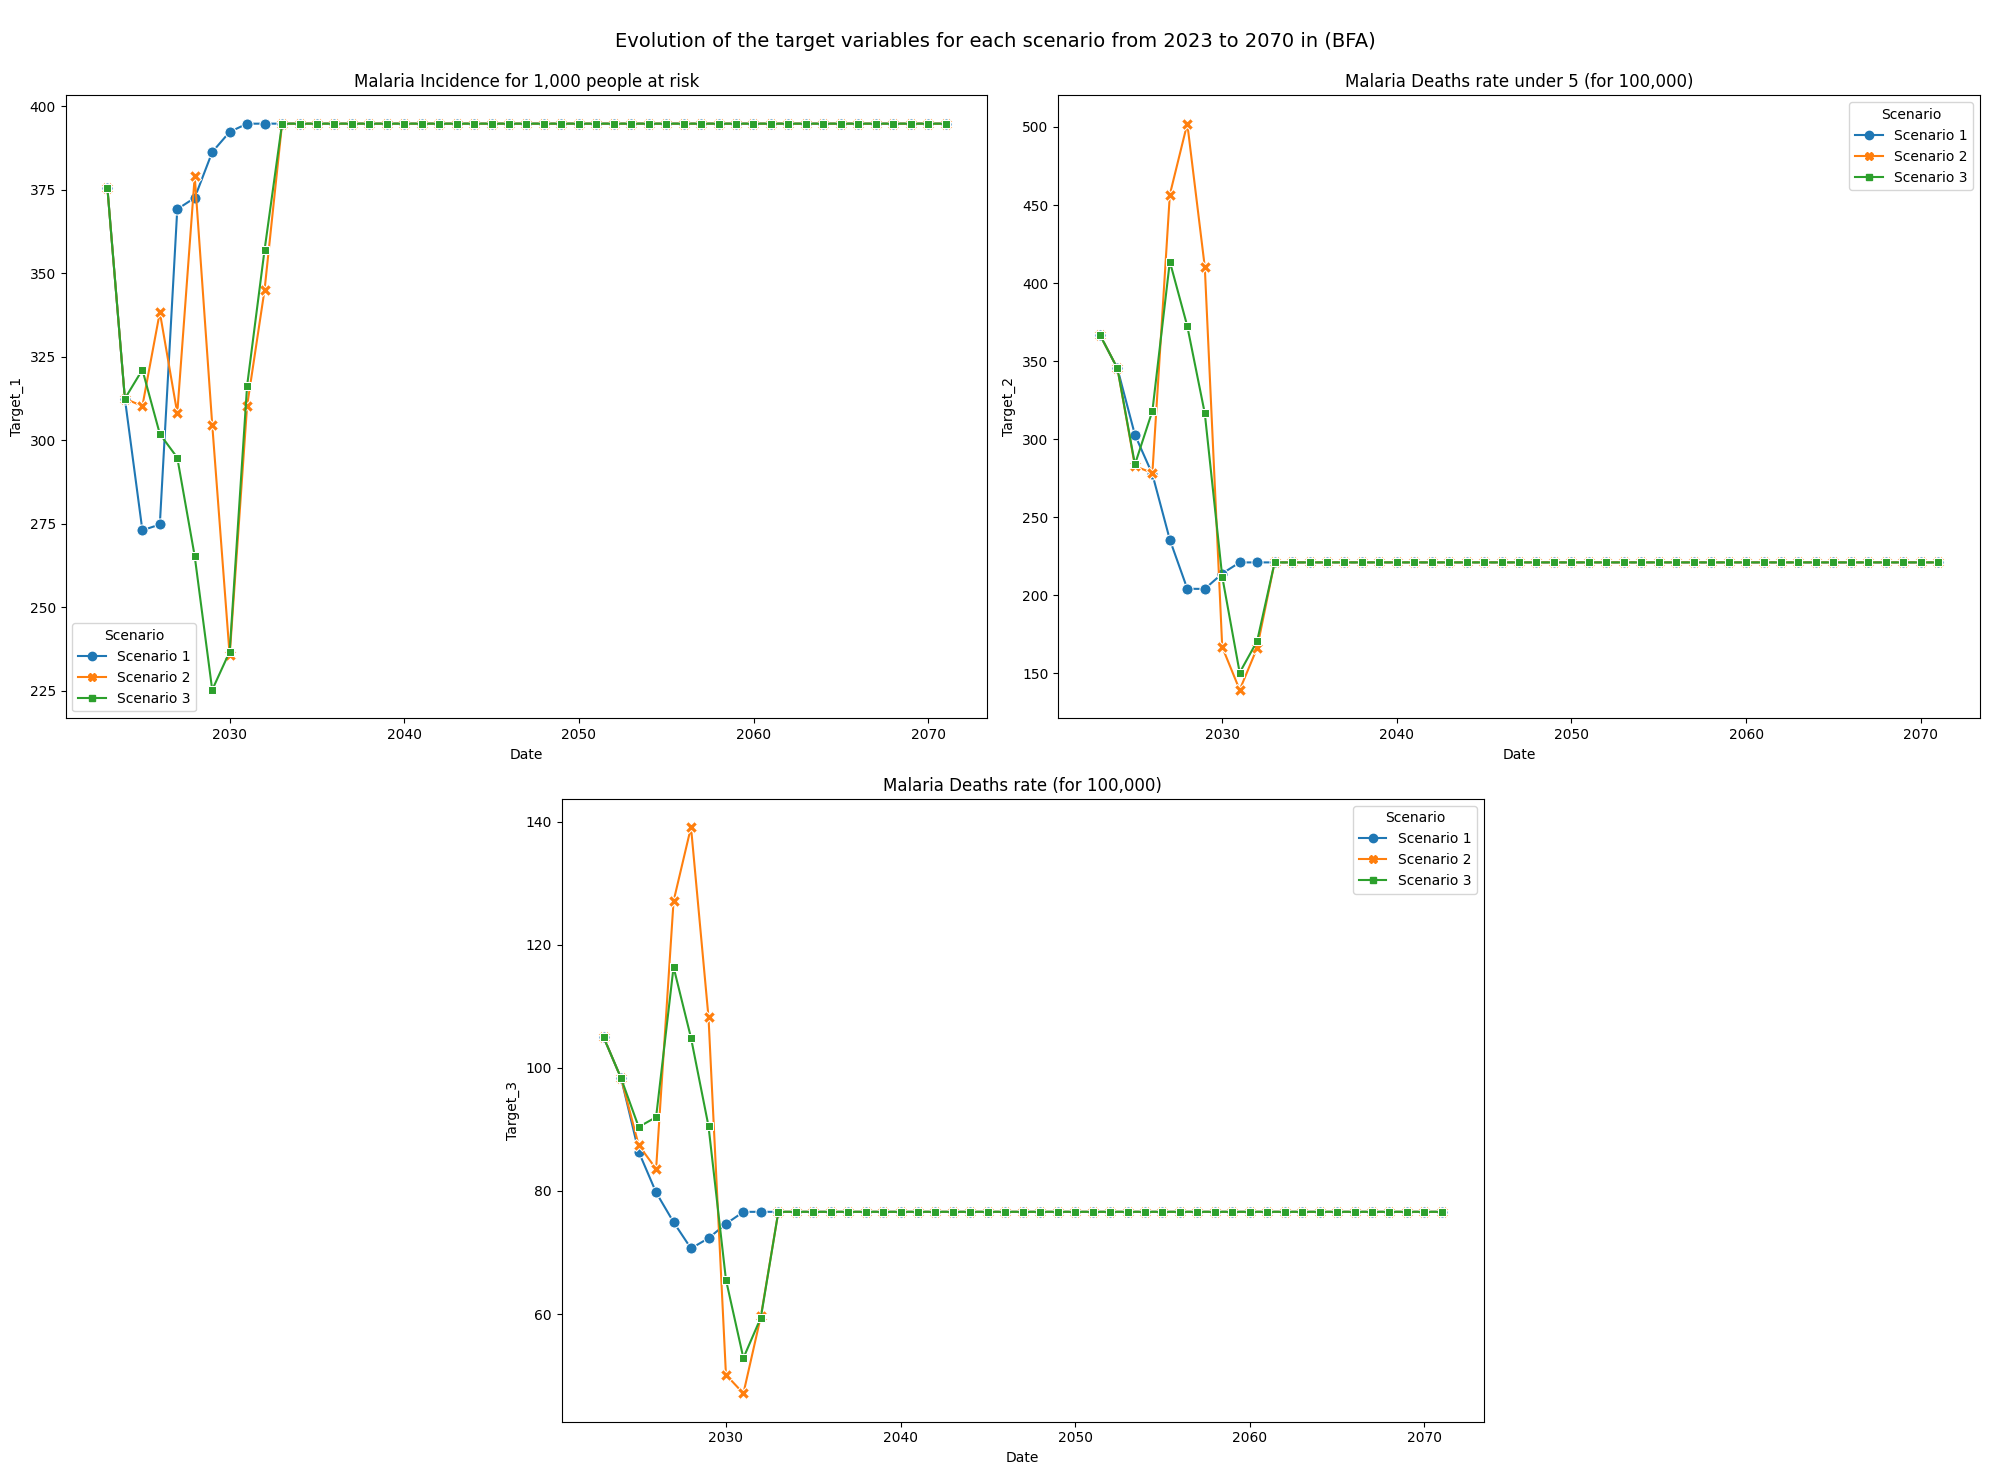

In [68]:
targets_dict = {
    "Target_1": 'Malaria Incidence for 1,000 people at risk',
    "Target_2": 'Malaria Deaths rate under 5 (for 100,000)',
    "Target_3": "Malaria Deaths rate (for 100,000)",
}
plotmaker.serve_predictions(
    data=predictions.reset_index(),
    scenario_column="Scenario",
    country="BFA",
    x_column="Date",
    variables=list(targets_dict.keys()), 
    nrows=2, 
    ncols=2, 
    figsize=(20, 15), 
    nfigs=3, 
    centered=True, 
    subtitles=list(targets_dict.values()),
    scenario="(Scenario 3-2)",
    predictions=True
)

### Ghana

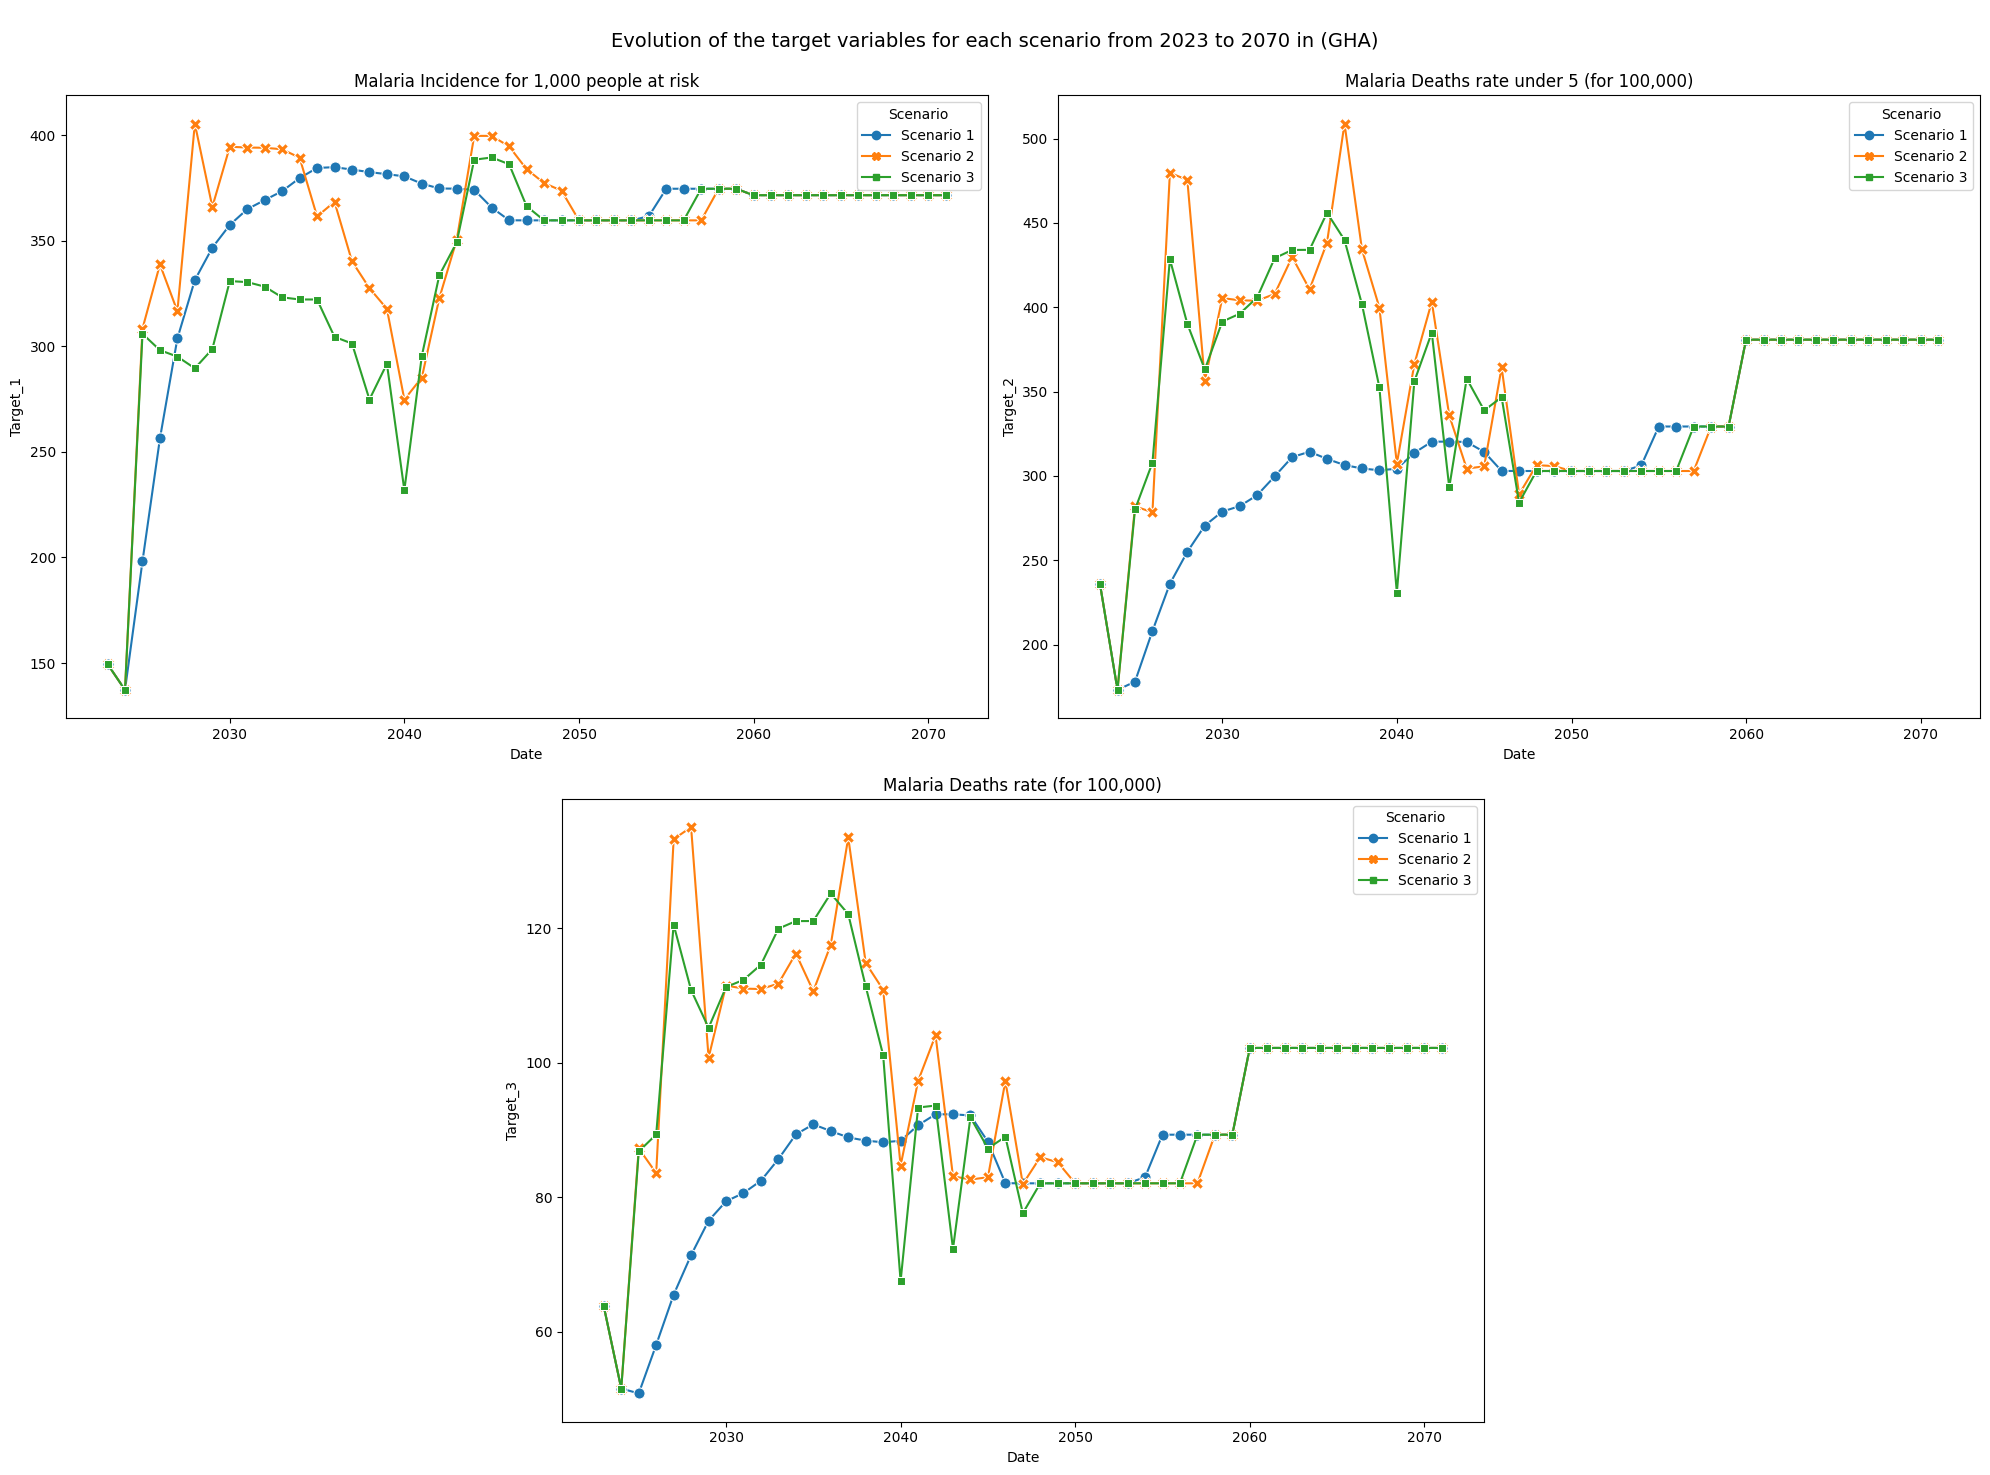

In [69]:
targets_dict = {
    "Target_1": 'Malaria Incidence for 1,000 people at risk',
    "Target_2": 'Malaria Deaths rate under 5 (for 100,000)',
    "Target_3": "Malaria Deaths rate (for 100,000)",
}
plotmaker.serve_predictions(
    data=predictions.reset_index(),
    scenario_column="Scenario",
    country="GHA",
    x_column="Date",
    variables=list(targets_dict.keys()), 
    nrows=2, 
    ncols=2, 
    figsize=(20, 15), 
    nfigs=3, 
    centered=True, 
    subtitles=list(targets_dict.values()),
    scenario="(Scenario 3-2)",
    predictions=True
)

### Kenya

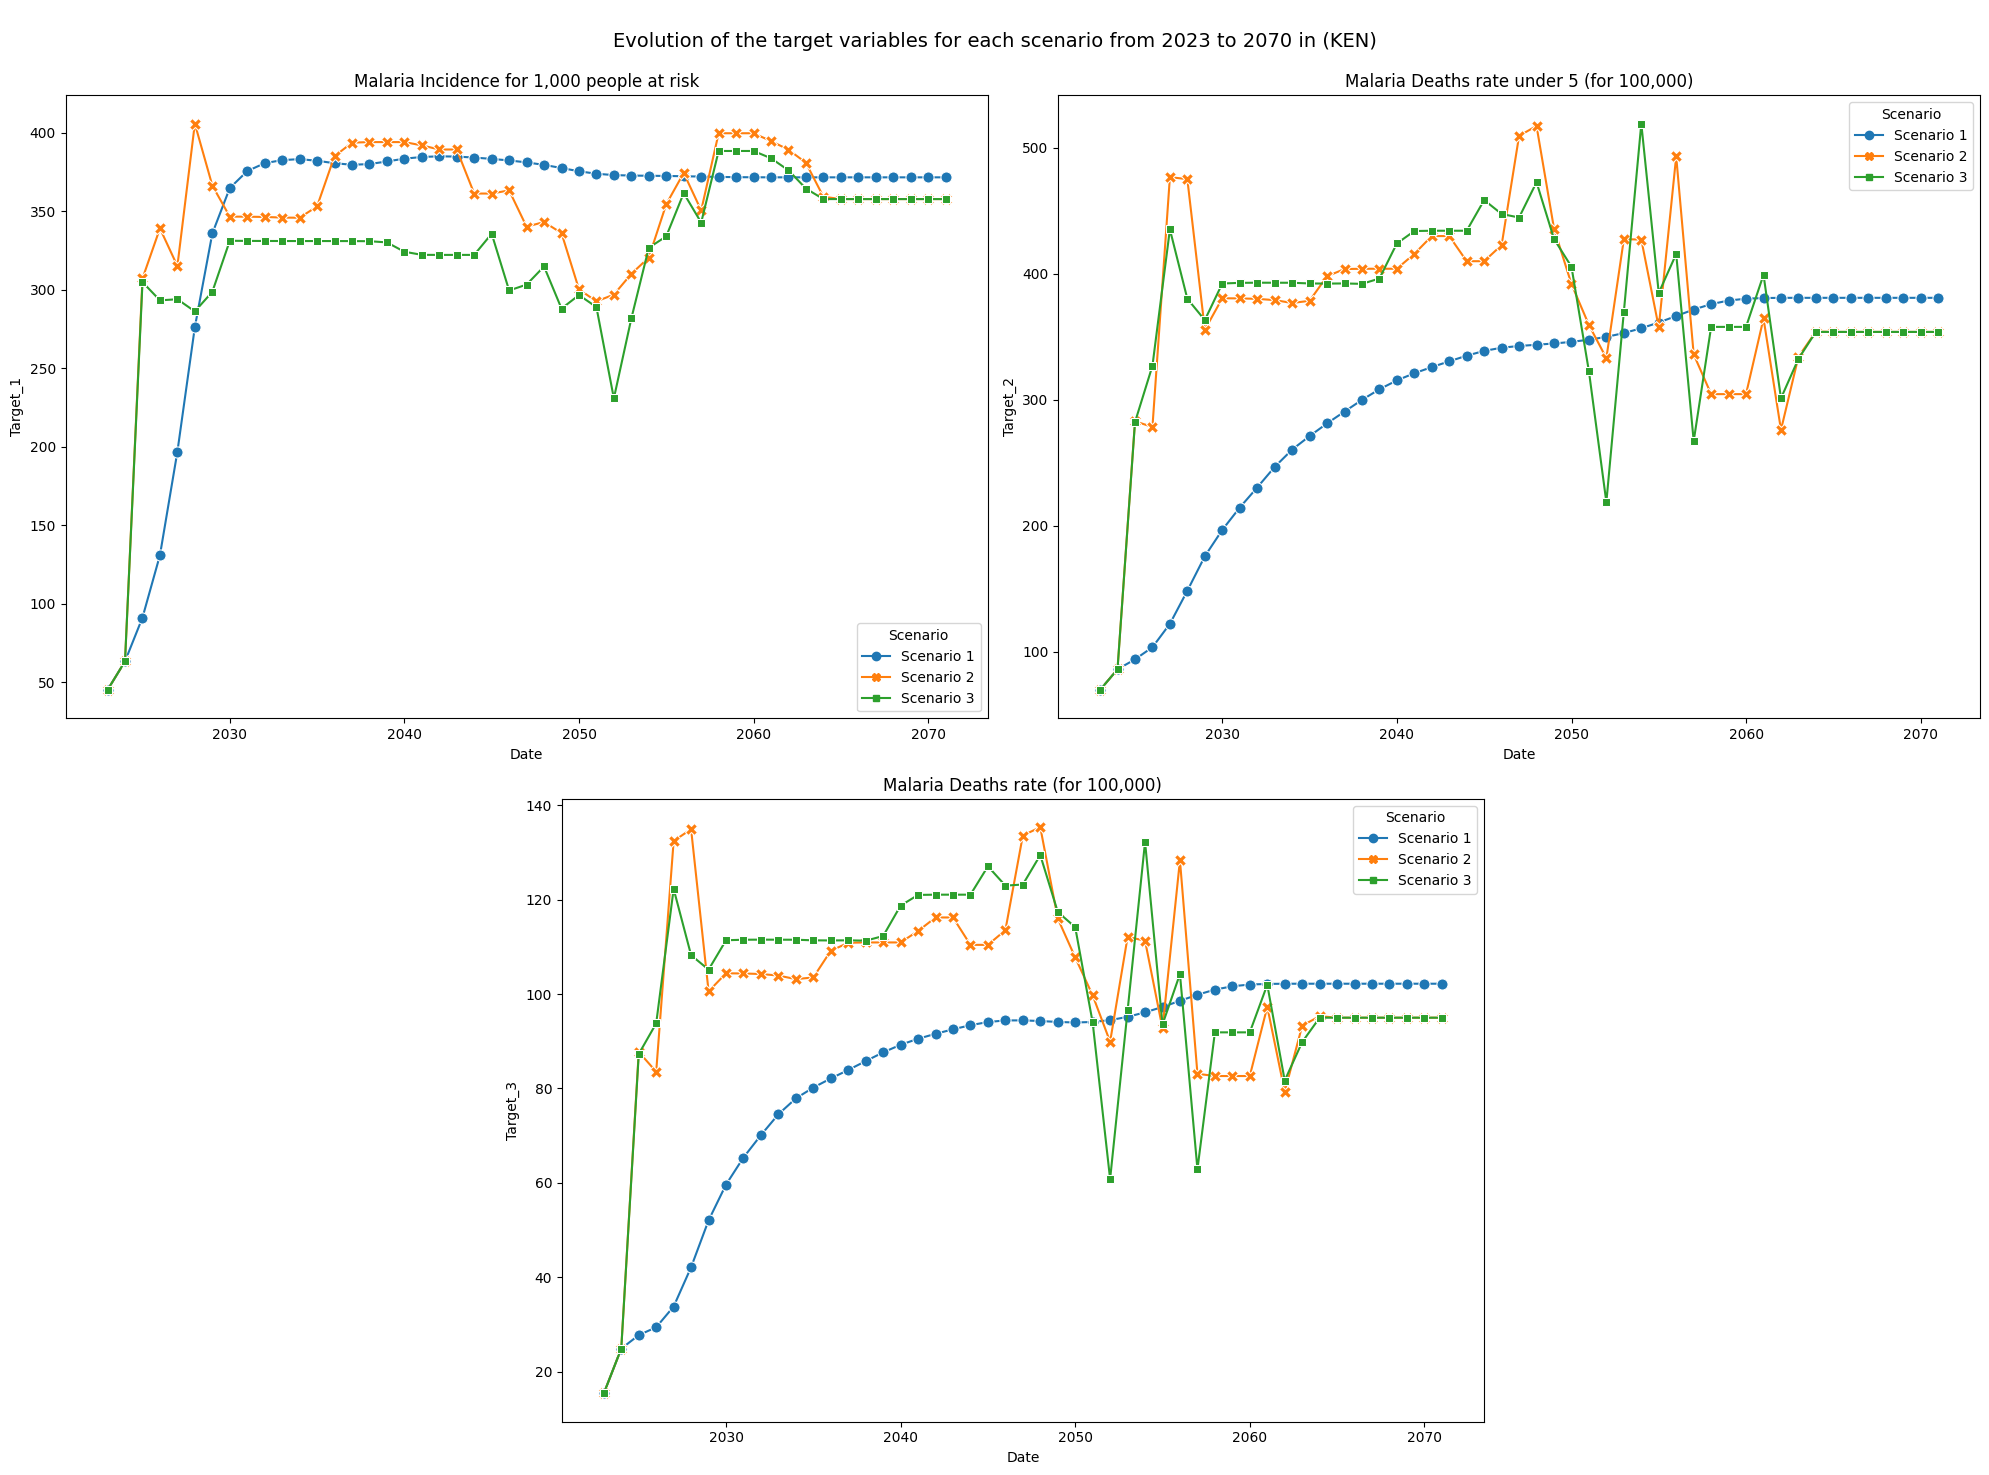

In [70]:
targets_dict = {
    "Target_1": 'Malaria Incidence for 1,000 people at risk',
    "Target_2": 'Malaria Deaths rate under 5 (for 100,000)',
    "Target_3": "Malaria Deaths rate (for 100,000)",
}
plotmaker.serve_predictions(
    data=predictions.reset_index(),
    scenario_column="Scenario",
    country="KEN",
    x_column="Date",
    variables=list(targets_dict.keys()), 
    nrows=2, 
    ncols=2, 
    figsize=(20, 15), 
    nfigs=3, 
    centered=True, 
    subtitles=list(targets_dict.values()),
    scenario="(Scenario 3-2)",
    predictions=True
)

### Malawi

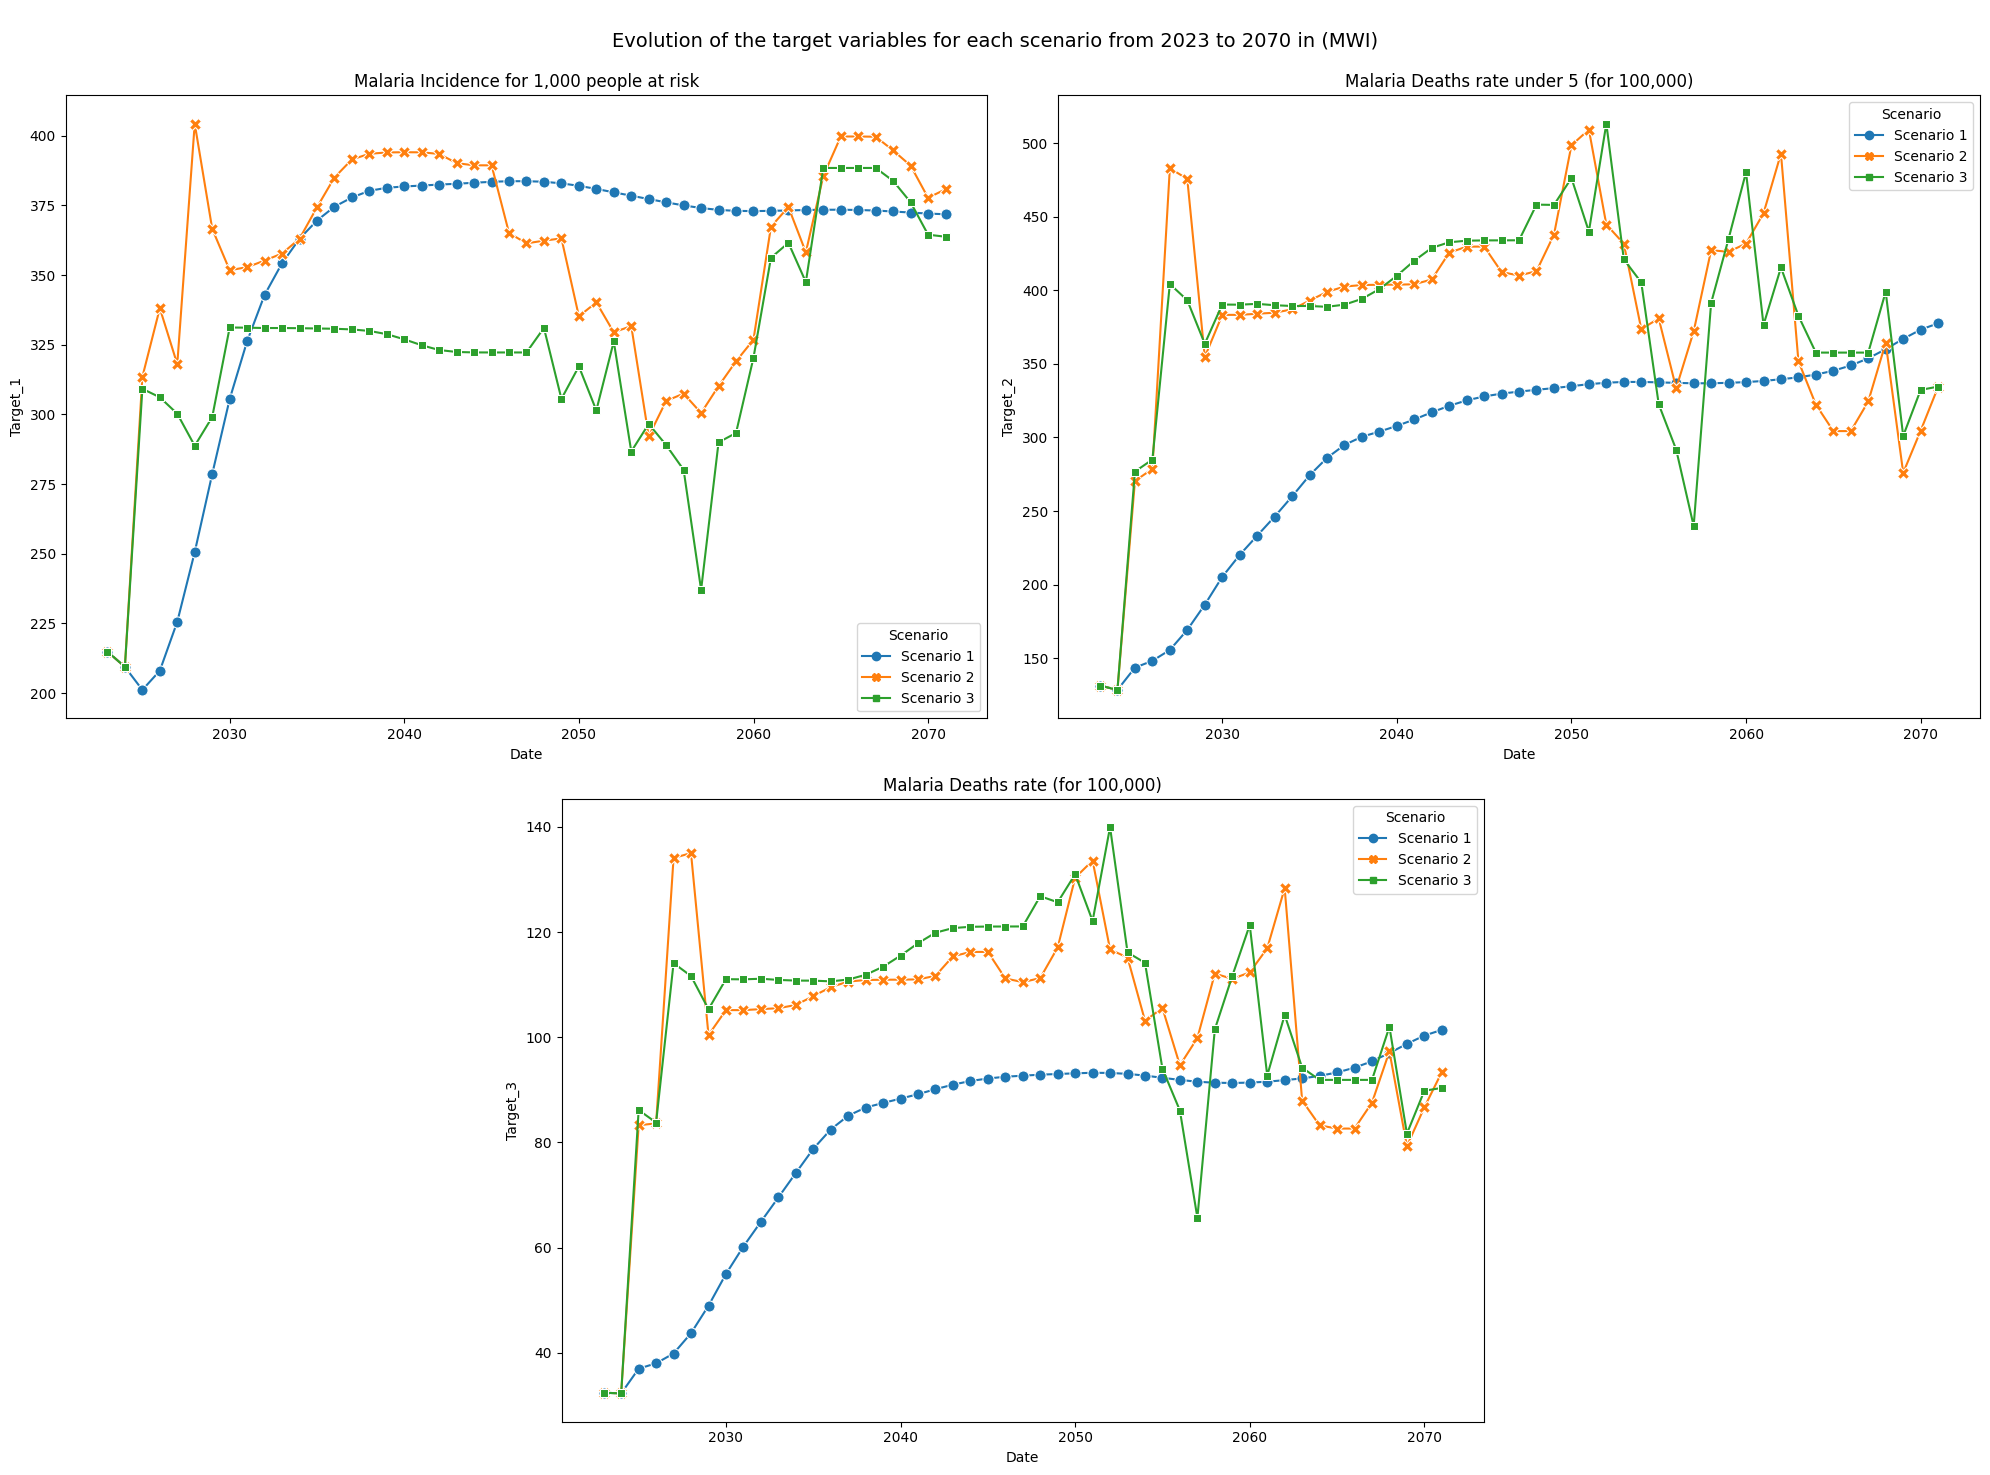

In [71]:
targets_dict = {
    "Target_1": 'Malaria Incidence for 1,000 people at risk',
    "Target_2": 'Malaria Deaths rate under 5 (for 100,000)',
    "Target_3": "Malaria Deaths rate (for 100,000)",
}
plotmaker.serve_predictions(
    data=predictions.reset_index(),
    scenario_column="Scenario",
    country="MWI",
    x_column="Date",
    variables=list(targets_dict.keys()), 
    nrows=2, 
    ncols=2, 
    figsize=(20, 15), 
    nfigs=3, 
    centered=True, 
    subtitles=list(targets_dict.values()),
    scenario="(Scenario 3-2)",
    predictions=True
)

### Nigeria

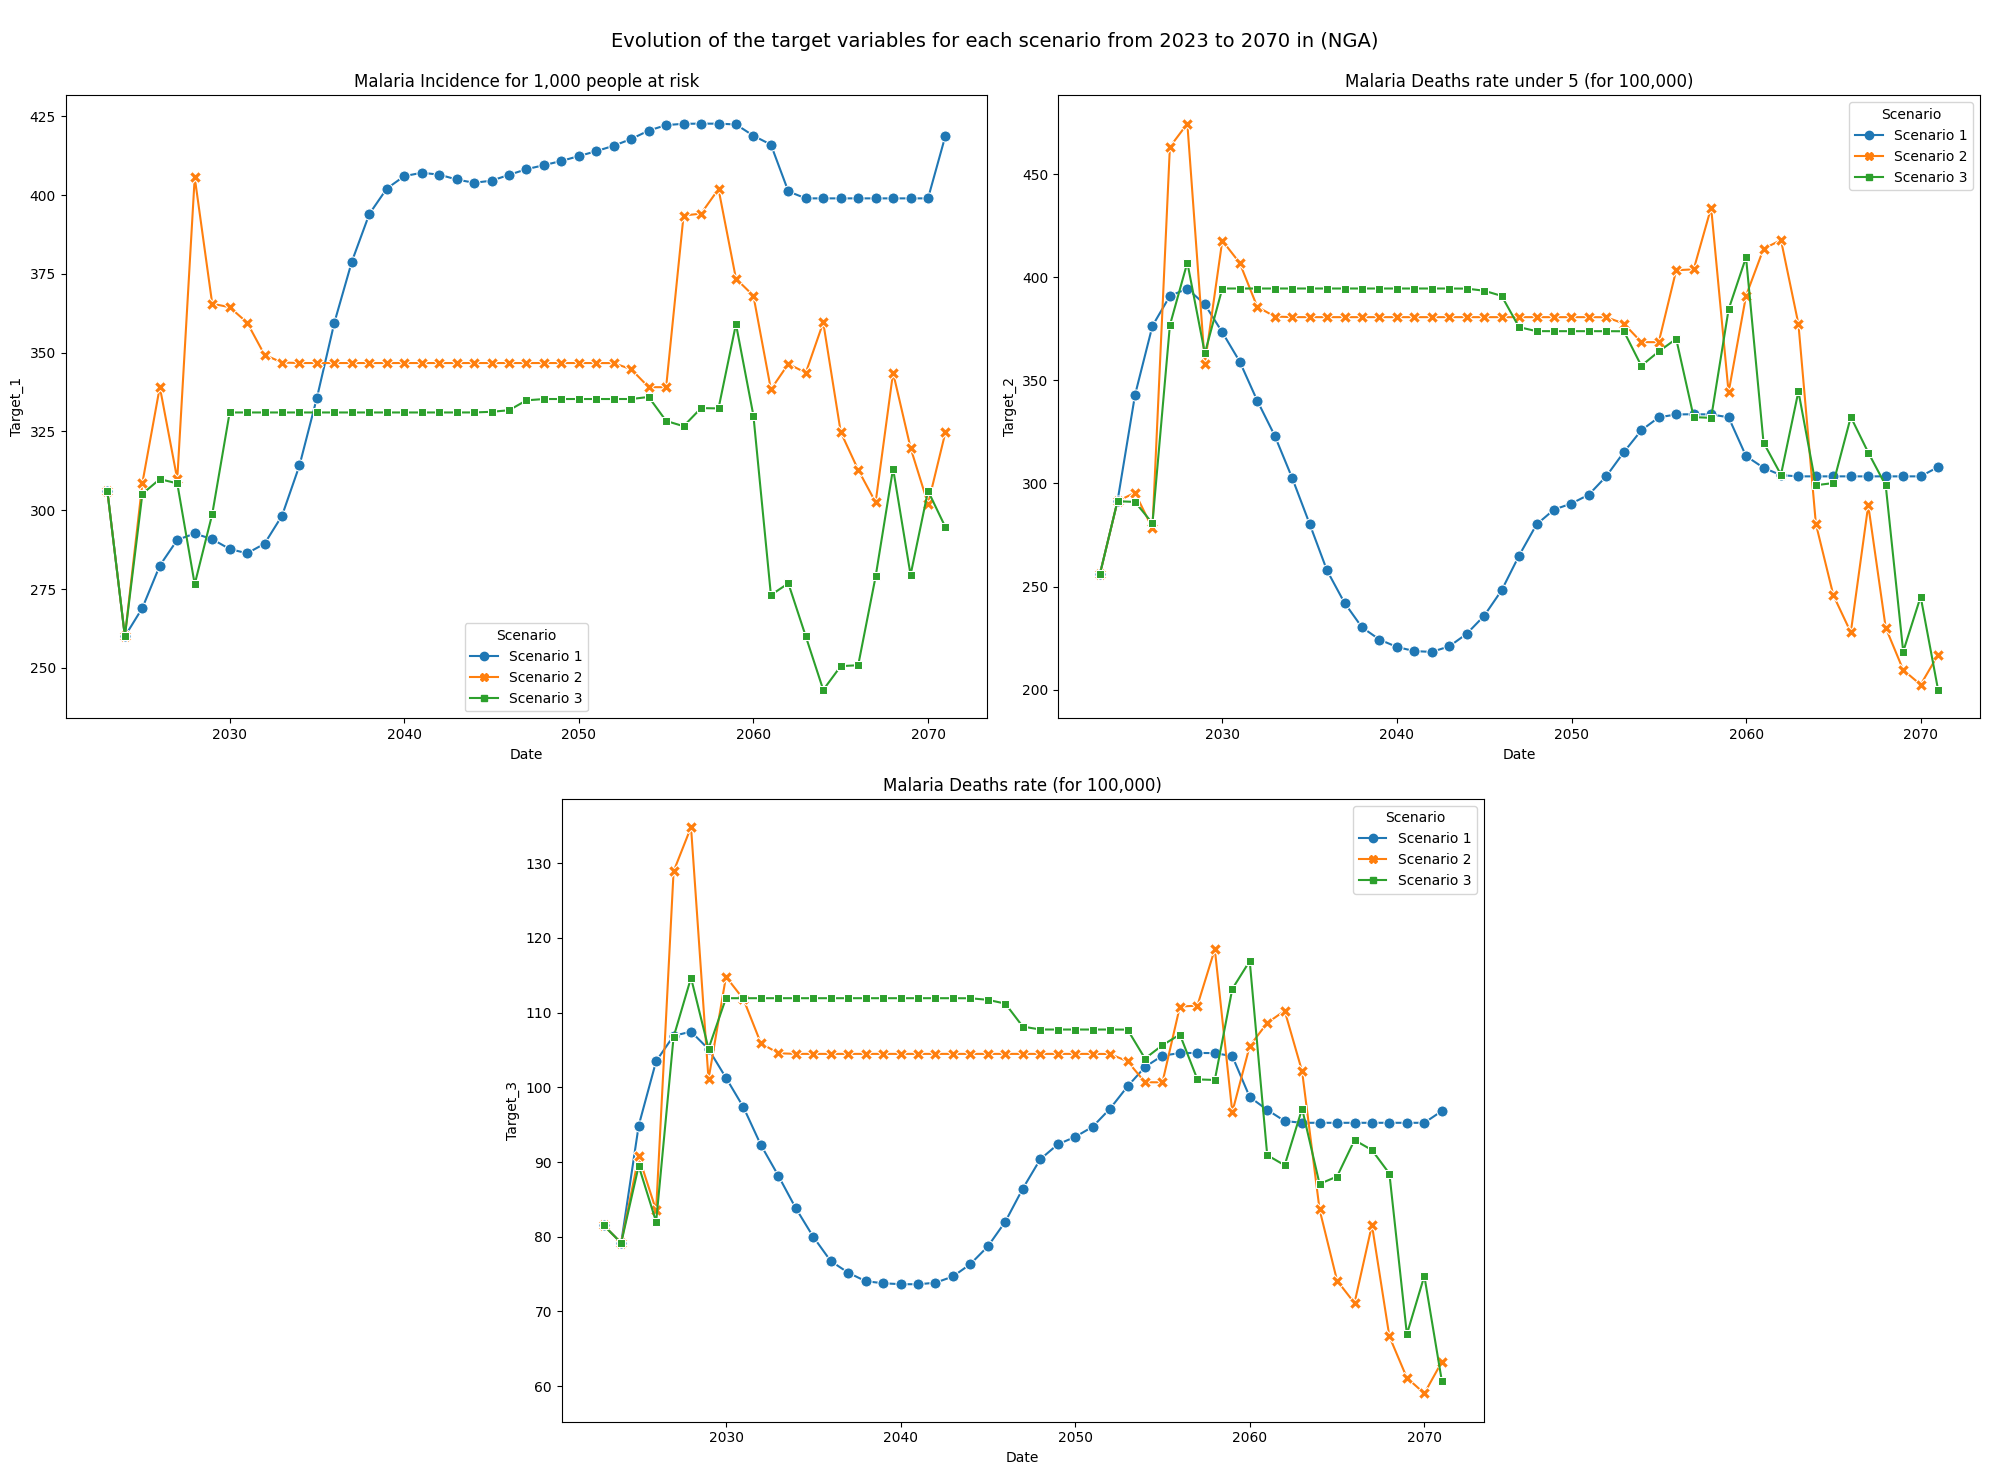

In [72]:
targets_dict = {
    "Target_1": 'Malaria Incidence for 1,000 people at risk',
    "Target_2": 'Malaria Deaths rate under 5 (for 100,000)',
    "Target_3": "Malaria Deaths rate (for 100,000)",
}
plotmaker.serve_predictions(
    data=predictions.reset_index(),
    scenario_column="Scenario",
    country="NGA",
    x_column="Date",
    variables=list(targets_dict.keys()), 
    nrows=2, 
    ncols=2, 
    figsize=(20, 15), 
    nfigs=3, 
    centered=True, 
    subtitles=list(targets_dict.values()),
    scenario="(Scenario 3-2)",
    predictions=True
)

In [73]:
# print("Case of BFA")
# display(pd.concat([bfa.set_index("Date")[target_columns].tail(1), (pred_2023["BFA"])]).pct_change())
# display(pd.concat([bfa.loc[bfa.Date == "2019-12-31", ["Date"] + target_columns].set_index("Date"), (pred_2023["BFA"])]).pct_change())